# VirtualiZarr Useful Recipes with NASA Earthdata

#### *Author: Dean Henze, PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

## Summary

This notebook goes through several functionalities of the VirtualiZarr package to create virtual reference files, specifically using it with NASA Earthdata and utilizing the `earthaccess` package. It is meant to be a quick-start reference that introduces some key capabilities / characteristics of the package once a user has a high-level understanding of virtual data sets and the cloud-computing challenges they address (see references in the *Prerequisite knowledge* section below). In short, VirtualiZarr is a Python package to create "reference files", which can be thought of as road maps for the computer to efficiently navigate through large arrays in a single data file, or across many files. Once a reference file for a data set is created, utilizing it to open the data can speed up several processes including lazy loading, accessing subsets, and in some cases performing computations. Importantly, one can create a combined reference for all the files in a dataset and use it to lazy load / access the entire record at once.

The functionalities of VirtualiZarr (with earthaccess) covered in this notebook are:

1. **Getting Data File endpoints in Earthdata Cloud** which are needed for virtualizarr to create reference files.
2. **Generating reference files for 1 day, 1 year, and the entire record of a ~750 GB data set**. The data set used is the Level 4 global gridded 6-hourly wind product from the Cross-Calibrated Multi-Platform project (https://doi.org/10.5067/CCMP-6HW10M-L4V31), available on PO.DAAC. This section also covers speeding up the reference creation using parallel computing. Reference files are saved in both JSON and PARQUET formats. The latter is an important format as it reduces the reference file size by ~30x in our tests. *Saving in ice chunk formats will be tested / covered in the coming months.*
3. **Combining reference files (in progress)**. The ability to combine reference files together is valuable, for example to upate reference files for forward-streaming datasets when new data are available, without re-creating the entire record from scratch. However, with the current workflows and version of VirtualiZarr, this is not possible due to our use of a specific kwarg when creating the reference files. The workflow is still included here (with errors) because it is anticipated that this will be fixed in upcoming versions. Alternately, the use of ice chunk will also likely solve this issue (ice chunk functionality to be tested soon). 

## Requirements, prerequisite knowledge, learning outcomes

#### Requirements to run this notebook

* Earthdata login account: An Earthdata Login account is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account.

* Compute environment: This notebook is meant to be run in the cloud (AWS instance running in us-west-2). We used an `m6i.4xlarge` EC2 instance (16 CPU's, 64 GiB memory) for the parallel computing sections. At minimum we recommend a VM with 10 CPU's to make the parallel computations in Section 2.2.1 faster.

* Optional Coiled account: To run the section on distributed clusters, Create a coiled account (free to sign up), and connect it to an AWS account. For more information on Coiled, setting up an account, and connecting it to an AWS account, see their website [https://www.coiled.io](https://www.coiled.io). 

#### Prerequisite knowledge

* This notebook covers virtualizarr functionality but does not present the high-level ideas behind it. For an understanding of reference files and how they are meant to enhance in-cloud access to file formats that are not cloud optimized (such netCDF, HDF), please see e.g. this [kerchunk page](https://fsspec.github.io/kerchunk/), or [this page on virtualizarr](https://virtualizarr.readthedocs.io/en/latest/).

* Familiarity with the `earthaccess` and `Xarray` packages. Familiarity with directly accessing NASA Earthdata in the cloud. 

* The Cookbook notebook on [Dask basics](https://podaac.github.io/tutorials/notebooks/Advanced_cloud/basic_dask.html) is handy for those new to parallel computating.

#### Learning Outcomes

This notebook serves both as a pedagogical resource for learning several key workflows as well as a quick reference guide. Readers will gain the understanding to combine the virtualizarr and earthaccess packages to create virtual dataset reference files for NASA Earthdata.

## Import Packages
#### ***Note Zarr Version***
***Zarr version 2 is needed for the current implementation of this notebook, due to (as of February 2025) Zarr version 3 not accepting `FSMap` objects.***

We ran this notebook in a Python 3.12 environment. The minimal working environment we used to run this notebook was:
```
zarr==2.18.4
fastparquet==2024.5.0
xarray==2025.1.2
earthaccess==0.11.0
fsspec==2024.10.0
dask==2024.5.2 ("dask[complete]"==2024.5.2 if using pip)
h5netcdf==1.3.0
matplotlib==3.9.2
jupyterlab
jupyter-server-proxy
virtualizarr==1.3.0
kerchunk==0.2.7
```
And optionally:
```
coiled==1.58.0
```

In [1]:
# Built-in packages
import os
import sys

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import xarray as xr
from virtualizarr import open_virtual_dataset

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import boto3
import numpy as np


In [2]:
virtual_collection = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/smap/open/docs/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6_virtual.json"


## Other Setup

In [3]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

## 1. Get Data File https endpoints


In [4]:
# Get Earthdata creds
earthaccess.login()

In [5]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
# fs = earthaccess.get_s3_filesystem(daac="PODAAC")
fs = earthaccess.get_fsspec_https_session() 

In [6]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.


In [7]:
# Open data using the reference file, using a small wrapper function around xarray's open_dataset. 
# This will shorten code blocks in other sections. 
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "https", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

In [8]:
%%time
data_example = opends_withref(virtual_collection, fs)
print(data_example)

<xarray.Dataset> Size: 1TB
Dimensions:                 (time: 3616, lat: 720, lon: 1440,
                             iceflag_components: 3, uncertainty_components: 9)
Coordinates:
  * lat                     (lat) float32 3kB -89.88 -89.62 ... 89.62 89.88
  * lon                     (lon) float32 6kB 0.125 0.375 0.625 ... 359.6 359.9
  * time                    (time) datetime64[ns] 29kB 2015-04-01T12:00:00 .....
Dimensions without coordinates: iceflag_components, uncertainty_components
Data variables: (12/19)
    anc_sea_ice_flag        (time, lat, lon, iceflag_components) float32 45GB dask.array<chunksize=(1, 720, 1440, 2), meta=np.ndarray>
    fland                   (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    gice_est                (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    gland                   (time, lat, lon) float64 30GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs    

In [9]:
# Also useful to note, these reference objects don't take much memory:
print(sys.getsizeof(data_example), "bytes")

120 bytes


In [10]:
# Start up cluster and print some information about it:
client = Client(n_workers=15, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(3a66a887, 'tcp://127.0.0.1:57113', workers=15, threads=15, memory=64.00 GiB)
View any work being done on the cluster here http://127.0.0.1:8787/status


In [11]:
rf = data_example.sss_smap_RF
rf

<xarray.DataArray 'sss_smap_RF' (time: 3616, lat: 720, lon: 1440)> Size: 30GB
dask.array<open_dataset-sss_smap_RF, shape=(3616, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 29kB 2015-04-01T12:00:00 ... 2025-05-20T12...
Attributes: (6)

In [12]:
dates = slice('2023-01-01', '2023-12-31')
rf.sel(time=dates)

<xarray.DataArray 'sss_smap_RF' (time: 365, lat: 720, lon: 1440)> Size: 3GB
dask.array<getitem, shape=(365, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 3kB 2023-01-01T12:00:00 ... 2023-12-31T12:...
Attributes: (6)

In [13]:
# Mediterranean Sea
#lats = slice(32, 48)
#lons = slice(-10, 40)

# Atlantic Ocean Area
# lats = slice(30, 45)
# lons = slice(315, 330)

#gulf of Mexico
lats = slice(15, 35)
lons = slice(255, 285)


sss = rf.sel(lat=lats, lon=lons, time=slice('2023-01-01', '2023-12-31'))
sss

<xarray.DataArray 'sss_smap_RF' (time: 365, lat: 80, lon: 120)> Size: 28MB
dask.array<getitem, shape=(365, 80, 120), dtype=float64, chunksize=(1, 80, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 320B 15.12 15.38 15.62 15.88 ... 34.38 34.62 34.88
  * lon      (lon) float32 480B 255.1 255.4 255.6 255.9 ... 284.4 284.6 284.9
  * time     (time) datetime64[ns] 3kB 2023-01-01T12:00:00 ... 2023-12-31T12:...
Attributes: (6)

In [14]:
%%time
sss.load()

CPU times: user 7.74 s, sys: 2.64 s, total: 10.4 s
Wall time: 1min 1s


<xarray.DataArray 'sss_smap_RF' (time: 365, lat: 80, lon: 120)> Size: 28MB
array([[[33.62477493, 33.6615181 , 33.69913483, ..., 35.58314514,
         35.66027069, 35.66846848],
        [33.86365128, 33.67233658, 33.73927689, ..., 35.5418396 ,
         35.62309265, 35.4393158 ],
        [34.11712265, 33.99905396, 33.80615616, ..., 35.461483  ,
         35.44747543, 35.36716843],
        ...,
        [        nan,         nan,         nan, ..., 36.58691025,
         36.62182617, 36.76387405],
        [        nan,         nan,         nan, ..., 36.34085464,
         36.44366455, 36.664505  ],
        [        nan,         nan,         nan, ..., 35.82963562,
         36.55550766, 36.55484772]],

       [[33.60402679, 33.60993576, 33.68273163, ..., 35.79496765,
         35.66547012, 35.41289902],
        [33.76466751, 33.62772751, 33.62989426, ..., 35.68995285,
         35.65943527, 35.23613739],
        [33.79190445, 33.70500946, 33.680233  , ..., 35.48931885,
         35.45115662, 35.25293732],
...
        [        nan,         nan,         nan, ..., 36.58375549,
         36.43651962, 36.63305664],
        [        nan,         nan,         nan, ..., 35.94322968,
         35.84147644, 36.34258652],
        [        nan,         nan,         nan, ..., 35.84163284,
         35.72860336, 36.00452805]],

       [[33.59130859, 33.58418274, 33.67615128, ..., 36.0834465 ,
         36.03343201, 35.98918915],
        [33.52467346, 33.62204742, 33.65102005, ..., 36.09127808,
         36.1505928 , 36.04559708],
        [33.53653336, 33.62895584, 33.61906052, ..., 36.09374619,
         36.13817596, 36.12014008],
        ...,
        [        nan,         nan,         nan, ..., 36.58375549,
         36.43651962, 36.63305664],
        [        nan,         nan,         nan, ..., 35.94322968,
         35.84147644, 36.34258652],
        [        nan,         nan,         nan, ..., 35.84163284,
         35.72860336, 36.00452805]]], shape=(365, 80, 120))
Coordinates:
  * lat      (lat) float32 320B 15.12 15.38 15.62 15.88 ... 34.38 34.62 34.88
  * lon      (lon) float32 480B 255.1 255.4 255.6 255.9 ... 284.4 284.6 284.9
  * time     (time) datetime64[ns] 3kB 2023-01-01T12:00:00 ... 2023-12-31T12:...
Attributes: (6)

(array([8.00000e+00, 7.60000e+01, 2.26000e+02, 9.79000e+02, 4.24900e+03,
        9.96240e+04, 7.61360e+05, 6.17883e+05, 1.06200e+03, 9.00000e+00]),
 array([20.59062576, 22.82388573, 25.05714569, 27.29040565, 29.52366562,
        31.75692558, 33.99018555, 36.22344551, 38.45670547, 40.68996544,
        42.9232254 ]),
 <BarContainer object of 10 artists>)

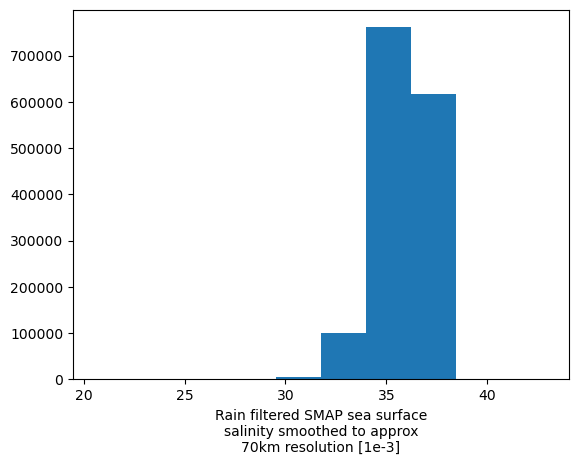

In [15]:
sss.plot()

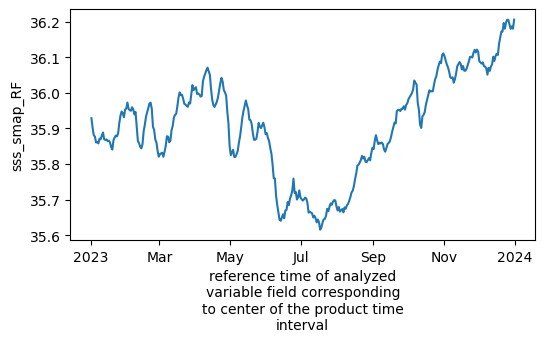

In [16]:
mean_sss = sss.mean(dim=["lat","lon"])
mean_sss.plot(aspect=2, size=3)


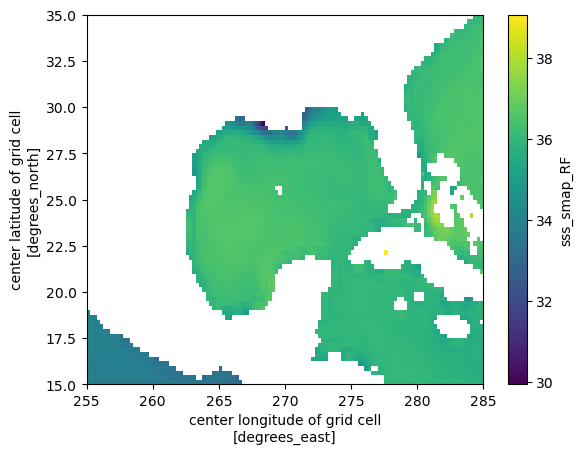

In [18]:
sss.mean(dim=["time"]).plot()